# MNIST 手寫數字辨識 - Softmax Regression

## 目標
* 下載並熟悉 MNIST 資料集
* 建立 tensorflow softmax regression model
* 訓練 model 並計算出準確度

In [1]:
!pip install tensorflow
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


/home/nbuser/anaconda2_410/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


當我們在學習一個新的程式語言的時候，譬如 `java`, `python` 之類的語言的時候，第一堂課都是學習印出 "Hello World!"．而在機器學習的領域裡面，MNIST 就有著相當於 Hello World 的地位．

而什麼是 MNIST 呢？就是一個手寫數字的資料集．它包含了一連串的手寫數字圖片，並且有相對應的數字，如下圖，看得出來就是 5, 0, 4, 1 這四個數字．

![](https://www.tensorflow.org/images/MNIST.png)

在這裡會嘗試用一個簡單的 Softmax Regression 的模型來解決這個問題，當然沒辦法達到頂尖的辨識水準，不過會是一個好的開始，接下來也會學到比較複雜但更為準確的模型，讓我們先來看看 MNIST 資料集吧．

## 下載並熟悉 MNIST data

MNIST 資料集的官網是在[Yann LeCun's website](http://yann.lecun.com/exdb/mnist/)．這裡我們只要在 python 內把以下的兩行程式碼貼上，就可以下載 MNIST 的資料集．

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


MNIST 資料集分成三個部分

1. 55,000 筆的 training data (`mnist.train`)
2. 10,000 筆的 test data (`mnist.test`)
3. 5,000 筆的 validation data (`mnist.validation`)

把資料集分成這三個部分在機器學習裡面是非常重要的，因為我們必須從學習資料以及驗證資料來看我們的學習到底有沒有效果 (generalizes)

如同上面講到的，每筆 MNIST 資料都有兩個部分，第一個是手寫的數字 image，另一個是對應的 label．在這裡我們把 image 稱作 `x`，而 label 稱作 `y`． training set 還有 test set 都有 image 以及 label．例如 training images 被稱作 `mnist.train.images`， training labels 稱作 `mnist.train.labels`．

In [3]:
# 來看看 mnist 的型態
print type(mnist)
print mnist.train.num_examples
print mnist.validation.num_examples
print mnist.test.num_examples

<class 'tensorflow.contrib.learn.python.learn.datasets.base.Datasets'>
55000
5000
10000


In [4]:
print("讓我們看一下 MNIST 訓練還有測試的資料集長得如何")
train_img = mnist.train.images
train_label = mnist.train.labels
test_img = mnist.test.images
test_label = mnist.test.labels
print
print(" train_img 的 type : %s" % (type(train_img)))
print(" train_img 的 dimension : %s" % (train_img.shape,))
print(" train_label 的 type : %s" % (type(train_label)))
print(" train_label 的 dimension : %s" % (train_label.shape,))
print(" test_img 的 type : %s" % (type(test_img)))
print(" test_img 的 dimension : %s" % (test_img.shape,))
print(" test_label 的 type : %s" % (type(test_label)))
print(" test_label 的 dimension : %s" % (test_label.shape,))

讓我們看一下 MNIST 訓練還有測試的資料集長得如何

 train_img 的 type : <type 'numpy.ndarray'>
 train_img 的 dimension : (55000, 784)
 train_label 的 type : <type 'numpy.ndarray'>
 train_label 的 dimension : (55000, 10)
 test_img 的 type : <type 'numpy.ndarray'>
 test_img 的 dimension : (10000, 784)
 test_label 的 type : <type 'numpy.ndarray'>
 test_label 的 dimension : (10000, 10)


從上面可以看到每個 image 有 784 個數字，因為每張圖片其實是 28 pixels X 28 pixels，我們可以把它看成一個很大的 array 如下圖

![](https://www.tensorflow.org/images/MNIST-Matrix.png)

把這個 array `拉平` 成一個 28x28 = 784 的向量，是用什麼方法拉平的並不重要，只要確保對於每張圖片都是用同樣的方法拉平就可以了．從這個角度來看， MNIST 就是一個 784 維向量空間裡面的點，只是有著比較複雜的[結構](http://colah.github.io/posts/2014-10-Visualizing-MNIST/)（注意，這個連結有很複雜的視覺化計算）

或許你會想問說把這個二維圖片變成一個向量，會不會造成什麼不好的效果．當然有一些更強大的電腦視覺技巧是可以學習這一些原始的數字結構的，之後我們還會看到．但在這裡我們使用的方法是 Softmax Regression ，他並不需要保留原始的數字結構，直接把它變成一個向量即可．

我們把 `mnist.train.images` 稱作一個 `tensor`（喔喔！tensorflow 的 tensor 出現了，他其實就是一個 n-dimensional array．而 tensor + flow = tensorflow，也就是指這個 n-dimensional array 變化流動的意思）這個 `tensor` 形狀為 [55000, 784]．第一個維度指的是圖片的 index，第二個則是每個圖片的 pixel 點，這個 pixel 點是一個介於 0 到 1 的值，來表示 pixel 點的強度．

![](https://www.tensorflow.org/images/mnist-train-xs.png)

而每個 MNIST 中的圖片都有一個對應的 label 也就是從 0 到 9 的數值．在這裡每個 label 都是一個 **one-hot vectors**． one-hot vector 是指說只有一個維度是 1 其他都是 0．在這裡數字 n 表示一個只有在第 n 維度（從 0 開始）數字為 1 的 10 維向量．例如 label 0 的表示法就是（[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]．因此，`mnist.train.labels` 是一個 [60000, 10] 的矩陣．

![](https://www.tensorflow.org/images/mnist-train-ys.png)

以下我們實際印出了 MNIST 的資料集來看看他長得怎麼樣

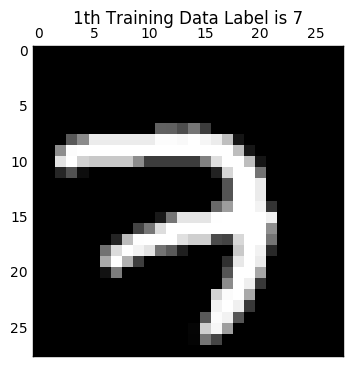

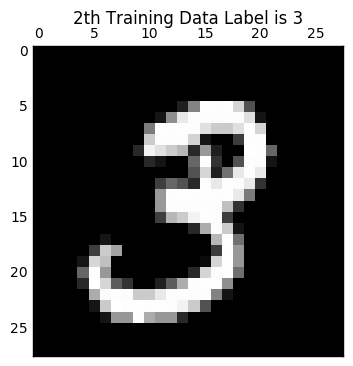

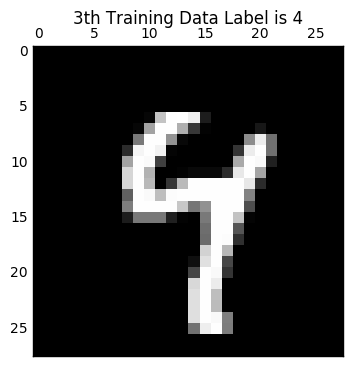

In [5]:
trainimg = mnist.train.images
trainlabel = mnist.train.labels
nsample = 1
randidx = np.random.randint(trainimg.shape[0], size=nsample)

for i in [0, 1, 2]:
    curr_img   = np.reshape(trainimg[i, :], (28, 28)) # 28 by 28 matrix 
    curr_label = np.argmax(trainlabel[i, :] ) # Label
    plt.matshow(curr_img, cmap=plt.get_cmap('gray'))
    plt.title("" + str(i + 1) + "th Training Data " 
              + "Label is " + str(curr_label))

## Softmax Regressions

我們知道 MNIST 裡面的手寫數字圖片都是從 0 到 9 的數字，因此我們想要知道給定一張圖片的時候對應到各個數字的機率是多少．例如我們的模型可能看了一張數字為 9 的圖片，模型不可能百分之百的確定他是某個數字，可能覺得有 80% 的機率為 9．然後有 5% 的機率是 8．剩餘的機率為其他數字．

`softmax regression` 是一個簡單且自然的模型，而 MNIST 就是一個經典的例子．`softmax` 的作用就是把機率分配給許多的類別，並且這些類別機率的加總為 1．即使是之後更複雜的模型，在模型最後一個階段仍然是使用 `softmax` 來分配機率．

`softmax regression` 有兩個步驟，第一個我們必須先蒐集對應類別的**證據** (`evidence`)，然後再把 `evidence` 轉化成機率．

為了得到一張給定圖片屬於哪一個數字的證據 (`evidence`) ，我們把圖片的 pixenl 加權求和．權重是負的表示這部分的 pixel 有很強的證據顯示突變並不屬於該數字，而如果很可能是這個數字，權重就會是正的．

下面的圖片顯示了模型從每個數字學習到的權值．紅色表示負權重，藍色表示正權重．

我們同樣加入了額外的 evidence 稱作**偏移量** (bias)．基本上我們會說這個證據是和輸入比較沒有關係的．結果是給定一個輸入 **x** 對應到的數字 **i** 他的證據如下:

$$\text{evidence}_i = \sum_j W_{i,~ j} x_j + b_i$$

其中 $$W_i, b_i$$ 分別是對應數字 i 的權重值以及偏移量．而 j

The following diagram shows the weights one model learned for each of these classes. Red represents negative weights, while blue represents positive weights.


We also add some extra evidence called a bias. Basically, we want to be able to say that some things are more likely independent of the input. The result is that the evidence for a class 
 given an input 
 is:

 
where 
 is the weights and 
 is the bias for class 
, and 
 is an index for summing over the pixels in our input image 
. We then convert the evidence tallies into our predicted probabilities 
 using the "softmax" function:

 
Here softmax is serving as an "activation" or "link" function, shaping the output of our linear function into the form we want -- in this case, a probability distribution over 10 cases. You can think of it as converting tallies of evidence into probabilities of our input being in each class. It's defined as:

 
If you expand that equation out, you get:

 
But it's often more helpful to think of softmax the first way: exponentiating its inputs and then normalizing them. The exponentiation means that one more unit of evidence increases the weight given to any hypothesis multiplicatively. And conversely, having one less unit of evidence means that a hypothesis gets a fraction of its earlier weight. No hypothesis ever has zero or negative weight. Softmax then normalizes these weights, so that they add up to one, forming a valid probability distribution. (To get more intuition about the softmax function, check out the section on it in Michael Nielsen's book, complete with an interactive visualization.)

You can picture our softmax regression as looking something like the following, although with a lot more 
s. For each output, we compute a weighted sum of the 
s, add a bias, and then apply softmax.


If we write that out as equations, we get:


We can "vectorize" this procedure, turning it into a matrix multiplication and vector addition. This is helpful for computational efficiency. (It's also a useful way to think.)


More compactly, we can just write:

 
Now let's turn that into something that Tensorflow can use.

## 實現 Regression

我們通常會用 Numpy 這類的套件來在 Python 中更有效率地處理像是矩陣相乘這樣的數值運算，而它會把這些計算移到 Python 外面，使用別種的程式語言還更有效率的實現方法．很不幸的是這樣的方法當把結果移回 Python 的時候會有 overhead 的情形．特別是在程式執行在 GPUs 或者分散式系統的時候，移動資料的成本會變得非常的高．

Tensorflow 同樣的也把這些計算移到 Python 外，但是它用了一些方法來避免 overhead．它先讓我們先敘述一個交互操作的圖，然後再把所有交互計算的過程移到 Python 外面，而不是只是在 Python 外面執行單一個昂貴的操作．(這樣的方式可以在一些機器學習套件中看到)

要開始執行 tensorflow 之前先讓我們 import 它．

In [6]:
import tensorflow as tf

我們用操作符號變數來描述這一些交互操作單元．讓我們來建立一個範例:

In [7]:
x = tf.placeholder(tf.float32, [None, 784])

`x` 不是一個特定的數值．他是一個佔位子 (`placeholder`)，是一個先要求 Tensorflow 預先保留的數值，在真正計算的時候才把數值輸入進去．我們想要可以輸入任意數量的 MNIST 圖片，每一張圖都會先轉化成 784 維的向量．用 2-D 的浮點數 tensor 來表現它．它的形狀是 `[None, 784]`．(這裡的 `None` 意味著它第一個維度可以是任一長度的．)

我們的模型同時需要權重還有偏移值．可以把它們看作一個額外的輸入，但是 Tensorflow有定義更好的方法來表示他們: `Variable`．一個 `Variable` 就是一個在 Tensorflow 交互操作圖中可以被變更的 tensor．他可以在計算中被取用和變更．在機器學習中，通常模型參數就會用 `Variables` 來表示．

In [8]:
W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))

我們經由給予 `tf.Variable` 初始值的方式來建立 Variable: 在這個例子中我們同時建立了 `W` 和 `b` 這兩個都為 0 的 tensor．因為 `W` 和 `b` 都會在學習過程中被學習出來，所以我們並不需要特別考慮他的初始值是多少．

值得注意的是 `W` 的形狀為 [784, 10] 因為我們想要把一個 784 維的向量經由矩陣相乘後產生一個 10 維的證據 (evidence）向量來表示不同的數字．b 則是一個長度為 10 的向量，然後我們可以把他加入最後的輸出中．

我們現在可以來實現我們的模型了．它僅僅需要一行來定義它!

In [9]:
y = tf.nn.softmax(tf.matmul(x, W) + b)

首先我們把 `x` 乘上 `W` 這裡的表示方式就是 `tf.matmul(x, W)` 對應了之前的矩陣相乘的數學式 **Wx**，`x` 是一個代表著多個輸入的 2D tensor．我們接下來把它加上 `b`，最後把它輸入 `tf.nn.softmax`．

到這裡，我們用了幾行程式來設定變數，然後再一行就建立起我們自己的模型了．Tensorflow 不僅僅可以讓 `softmax regression` 變得如此簡單，像是其他的數值運算，機器學習模型，甚至是物理學的模擬都可以利用 Tensorflow 來描述．而只要這些模型被定義後，它就可以在任何的設備上使用，例如你的電腦的 CPU 和 GPU，甚至是手機呢！

## 模型訓練

為了要訓練的我們的模型，我們必須先定義一下怎樣的模型才是好的模型．事實上在機器學習中，通常是定義一個模型怎樣算是不好的．我們把這個定義稱作成本 (cost) 或是損失 (loss)．它代表我們的模型和預期的結果間的差距．我們會嘗試要最小化這些成本，當這些成本或損失越低的時候，就代表著我們的模型越好．

有一個非常常見而且很棒的成本函數稱作 `cross-entropy`．它原先產生於通訊理論中的通訊壓縮編碼，但從賭博到機器學習等領域都有著很重要的地位．它的定義如下:

$$H_{y'}(y) = -\sum_i y'_i \log(y_i)$$

`y` 是預測的機率分佈，而 `y'` 是真實的機率分佈 (one-hot 數字向量)．概略地來說 `cross-entropy` 用來量測我們的預測和真相的之間的差距．更多的探討 `cross-entropy` 有點超出這裡這份的指引的範圍，但很推薦你好好地理解[它](http://colah.github.io/posts/2015-09-Visual-Information/)．

為了實現 `cross-entropy` 我們必須先加入一個新的佔位子 (placeholder) 來放置正確的答案．

In [10]:
y_ = tf.placeholder(tf.float32, [None, 10])

然後我們可以來實現 cross-entropy 函數, $-\sum y'\log(y)$:

In [11]:
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))

首先 `tf.log` 會先對每個 `y` 的元素取 log．接下來我們把每個 `y_` 中的元素乘上 `tf.log(y)` 中對應的元素．接下來使用 `tf.reduce_sum` 把第二個維度的元素加總起來，(reduction_indices=[1]，這個參數)．最後 `tf.reduce_mean` 計算出這一輪的平均值．

(在程式碼裡面我們並沒有直接使用這段程式碼，因為它是 numerically unstable．取而代之的我們使用 `tf.nn.softmax_cross_entropy_with_logits`．並把 `tf.matmul(x, W) + b` 當作函數輸入．在你自己的程式裡面請考慮使用 `tf.nn(sparse_)softmax_cross_entropy_with_logits`．

好的，現在我們已經知道我們要我們的模型做什麼了，而且 Tensorflow 也已經知道整個模型的計算流程圖了，現在就讓 Tensorflow 來幫你訓練模型吧．它可以自動的計算[反向傳遞](http://colah.github.io/posts/2015-08-Backprop/) (backpropagation algorithm)並且調整參數來讓成本 (lost) 最小化．當然的你可以自己選擇要使用哪一個調整參數的最佳化演算法．

In [12]:
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

在這個例子中，我們要 Tensorflow 使用梯度下降法 [gradient descent algorithm](https://en.wikipedia.org/wiki/Gradient_descent) 來最小化 `cross_entropy`，而它的學習速率 (learning rate) 是 0.5．梯度下降法 (Gradient descent) 是一個簡單的學習方法，Tensorflow 會把每個參數往最小化 cost 的方向調整．不過 Tensorflow 同時也提供了許多[最佳化](https://www.tensorflow.org/api_docs/python/train#optimizers)的演算法：而且只要調整一行的程式碼就可以使用這些演算法了．

實際上 Tensorflow 在這裡做的事情是在你所定義的計算圖用一系列後台的計算來實現反向傳遞以及梯度下降法．最後它給你的只是一個單一簡單的函數，當運行的時候，他就會利用梯度下降法來訓練你的模型參數，不斷地減低 cost．

現在我們已經設置好我們的模型了，但在執行之前還有最後一件事情是我們要先來初始化我們所建立的變數．注意一下這時候只是定義而已還沒有真正的執行．

In [13]:
init = tf.global_variables_initializer()

我們現在可以利用 `Session` 來初始化我們的參數以及啟動我們的模型了．

In [14]:
sess = tf.Session()
sess.run(init)

開始訓練模型！我們會執行 1000 次的訓練

In [21]:
for i in range(1000):
    batch_xs, batch_ys = mnist.train.next_batch(100)
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})

在每一次 loop 中我們會從訓練數據中隨機抓取一批 100 筆數據，然後把這些數據去替換掉之前我們設定的站位子 (`placeholder`)來進行訓練．

使用一小部分的隨機數據稱作隨機訓練 (stochastic training)，更精確地說是隨機梯度下降．理想上我們希望用所有的數據來訓練，這樣會有更好的訓練結果，但這樣需要很大的計算消耗．所以每一次使用不同的訓練子集，這樣做可以有一樣的效果但是比較少的計算消耗．

## 評估我們的模型

我們的模型表現的如何呢？
讓我們看看我們預測的數字是否正確．`tf.argmax` 是一個特別有用的函數，它可以讓我們找到在某一維的 tensor 中找到最大的數值的索引值 (index)．例如 `tf.argmax(y, 1)` 代表著模型對於每一筆輸入認為最有可能的數字，`tf.argmax(y_, 1)` 則是代表著正確的數字．我們可以使用 `tf.equal` 來確認我們的預測是否正確．


In [22]:
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))

這列出了一系列的布林值．為了來看看有多少比重的預測是正確的，我們把布林值轉化成福點數然後取平均值．例如 `[True, False, True, True]` 會變成 `[1, 0, 1, 1]`平均值是 `0.75`．

In [23]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

終於我們可以來印出我們的測試資料執行出來的準度了．

In [36]:
print(sess.run(accuracy, feed_dict = {x: mnist.test.images, y_: mnist.test.labels}))

[  7.95254346e-06   2.58060628e-10   2.88528317e-05   1.33952976e-03
   4.69748301e-07   8.23298251e-06   1.33806644e-09   9.98502851e-01
   4.31090166e-06   1.07761858e-04]


出來的結果大概是 92%

這樣的結果算是好的嗎？其實是非常差的．這是因為我們用的是非常簡單的模型．如果做一些小調整，可以得到 97% 的精準度．而最好的模型可以達到 99.7%！(更多的資訊可以看一下[一些結果](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html)．

重要的是我們從這個模型學到了什麼，如果你覺得這樣的結果很令人沮喪的話看一下接下來的[教材](https://www.tensorflow.org/tutorials/mnist/pros/index)吧！學習用 Tensorflow 來建立更好的模型！

In [37]:
print(sess.run(y[0,:], feed_dict = {x: mnist.test.images, y_: mnist.test.labels}))

[  7.95254346e-06   2.58060628e-10   2.88528317e-05   1.33952976e-03
   4.69748301e-07   8.23298251e-06   1.33806644e-09   9.98502851e-01
   4.31090166e-06   1.07761858e-04]
